## Gymnasium environments

This Section shows how you can make and use the `gym` environments that interface with the simulator.

In [22]:
import os
from pathlib import Path
import torch
import mediapy

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader

### Settings

In [23]:
MAX_NUM_OBJECTS = 64  # Maximum number of objects in the scene we control
NUM_WORLDS = 4  # Number of parallel environments
UNIQUE_SCENES = 3 # Number of unique scenes

device = 'cpu' # for simplicity purposes in notebook we use cpu, note that the simulator is optimized for GPU so use cuda if possible

### Initializing environments

- We provide both a torch and jax gymnasium interface with the simulator. Most functionality is specified in the `GPUDriveGymEnv` class in the `base_env`, `torch_env` and `jax_env` both inherit from the `GPUDriveGymEnv`, the only difference between these is that one exports torch tensors and the other jax arrays.
- All environment settings are defined in the `EnvConfig` dataclass. 


In [24]:
env_config = EnvConfig(
    steer_actions = torch.round(
        torch.linspace(-1.0, 1.0, 3), decimals=3),
    accel_actions = torch.round(
        torch.linspace(-3, 3, 3), decimals=3
    )
)

---

> 💡 **See the gym environment docs at [`pygpudrive/env`](https://github.com/Emerge-Lab/gpudrive/tree/main/pygpudrive/env)**

---

In [25]:
# Make dataloader
data_loader = SceneDataLoader(
    root="data/processed/examples", # Path to the dataset
    batch_size=NUM_WORLDS, # Batch size, you want this to be equal to the number of worlds (envs) so that every world receives a different scene
    dataset_size=UNIQUE_SCENES, # Total number of different scenes we want to use
    sample_with_replacement=False, 
    seed=42, 
    shuffle=True,   
)

# Make environment
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=data_loader,
    max_cont_agents=MAX_NUM_OBJECTS, # Maximum number of agents to control per scenario
    device=device,
)

In [26]:
env.data_batch

['data/processed/examples/tfrecord-00000-of-01000_402.json',
 'data/processed/examples/tfrecord-00000-of-01000_4.json',
 'data/processed/examples/tfrecord-00000-of-01000_325.json',
 'data/processed/examples/tfrecord-00000-of-01000_325.json']

### Rollout 

A single rollout (one episode) is implemented as follows. We:
- step through N worlds simultaneously.
- render the simulator state using `plot_simulator_state()`

In [27]:
obs = env.reset()

frames = {f"env_{i}": [] for i in range(NUM_WORLDS)}

for t in range(env_config.episode_len):
    
    # Sample random actions
    rand_action = torch.Tensor(
        [[env.action_space.sample() for _ in range(MAX_NUM_OBJECTS * NUM_WORLDS)]]
    ).reshape(NUM_WORLDS, MAX_NUM_OBJECTS)

    # Step the environment
    env.step_dynamics(rand_action)

    obs = env.get_obs()
    reward = env.get_rewards()
    done = env.get_dones()

    # Render the environment    
    if t % 5 == 0:
        imgs = env.vis.plot_simulator_state(
            env_indices=list(range(NUM_WORLDS)),
            time_steps=[t]*NUM_WORLDS,
            zoom_radius=50,
        )
    
        for i in range(NUM_WORLDS):
            frames[f"env_{i}"].append(img_from_fig(imgs[i])) 
        
    if done.all():
        break

### Display videos of agents taking random actions

env_0,env_1
env_2,env_3

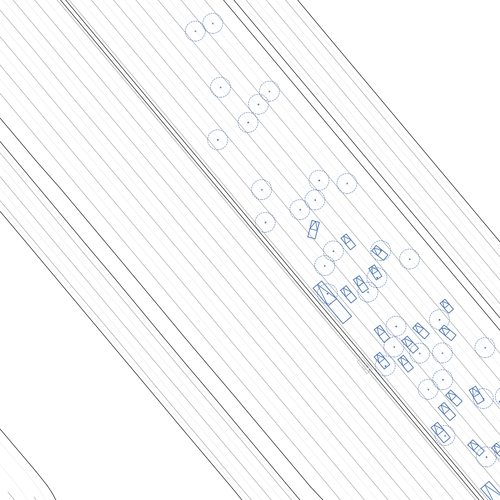
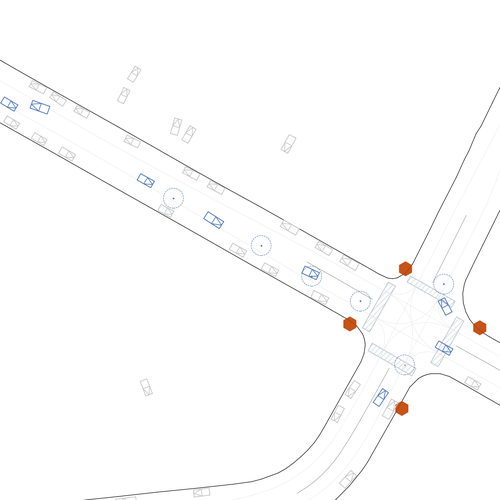
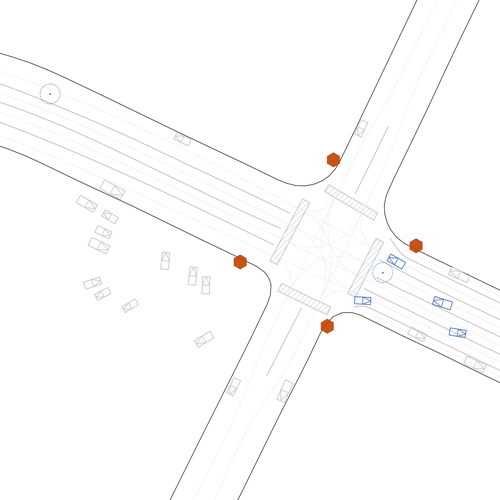
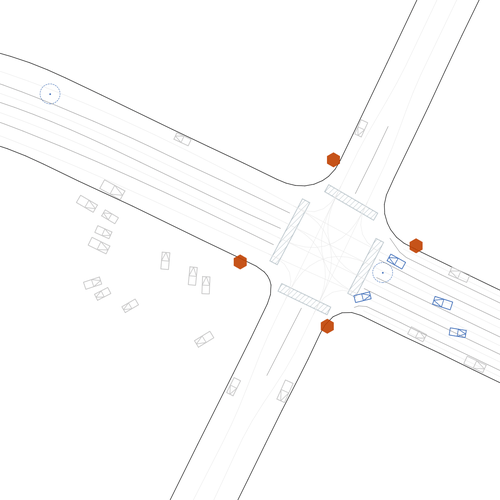

In [28]:
mediapy.show_videos(frames, fps=5, width=500, height=500, columns=2, codec='gif')